In [1]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import urllib
import numpy as np
import cv2
import keras
from imgaug import augmenters as iaa
import imgaug as ia
import os

Using TensorFlow backend.


In [2]:
import pandas as pd

In [7]:
df = pd.read_csv('../Histopathologic-Cancer-Detection/submission/train_labels.csv')

In [8]:
seq = iaa.Sequential([
  iaa.Fliplr(0.5, name="Flipper"),
  iaa.GaussianBlur((0, 3.0), name="GaussianBlur"),
  iaa.Dropout(0.02, name="Dropout"),
  iaa.AdditiveGaussianNoise(scale=0.01*255, name="MyLittleNoise"),
  iaa.AdditiveGaussianNoise(loc=32, scale=0.0001*255, name="SomeOtherNoise"),
  iaa.Affine(translate_px={"x": (-40, 40)}, name="Affine")
])

In [9]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(1,150,150), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def read_and_resize(self, filepath):
        img = cv2.imread(filepath)
        res = resize(img, (224, 224), preserve_range=True, mode='reflect')
        return np.expand_dims(res, 0)
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        X = [self.read_and_resize(self.list_IDs[i])
             for i in indexes]
        y = self.labels[indexes]
        X = np.vstack(X)
#         return seq.augment_images(X), y
        return (X, y)

In [10]:
from random import randint

In [11]:
print (list(df))

['id', 'label']


In [12]:
seq = iaa.Sequential([
  iaa.Fliplr(0.5, name="Flipper"),
#   iaa.GaussianBlur((0, 3.0), name="GaussianBlur"),
#   iaa.Dropout(0.02, name="Dropout"),
#   iaa.AdditiveGaussianNoise(scale=0.01*255, name="MyLittleNoise"),
#   iaa.AdditiveGaussianNoise(loc=32, scale=0.0001*255, name="SomeOtherNoise"),
#   iaa.Affine(translate_px={"x": (-40, 40)}, name="Affine")
])

In [13]:
path = '../Histopathologic-Cancer-Detection/train/{}.tif'.format(df['id'][randint(0, len(df['id']))])
print (path)

../Histopathologic-Cancer-Detection/train/42e98ffcf904801939c778e41616905e061d3199.tif


In [14]:
img = cv2.imread(path)
img = seq.augment_images(img)

/root/anaconda3/lib/python3.6/site-packages/imgaug/augmenters/meta.py:379: UserWarning: You provided a numpy array of shape (96, 96, 3) as input to augment_images(), which was interpreted as (N, H, W). The last dimension however has value 1 or 3, which indicates that you provided a single image with shape (H, W, C) instead. If that is the case, you should use augment_image(image) or augment_images([image]), otherwise you will not get the expected augmentations.
  "you will not get the expected augmentations." % (images_copy.shape,))


In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# img=mpimg.imread('your_image.png')
imgplot = plt.imshow(img)
plt.show()

<Figure size 640x480 with 1 Axes>

In [16]:
def show_random():
    path = '../Histopathologic-Cancer-Detection/train/{}.tif'.format(df['id'][randint(0, len(df['id']))])
    img = cv2.imread(path)
    img = seq.augment_images(img)
    imgplot = plt.imshow(img)
    plt.show()

In [81]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

In [17]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip
    iaa.OneOf([
        iaa.Noop(),
        iaa.GaussianBlur(sigma=(0.0, 1.0)),
        iaa.Noop(),
        iaa.Affine(rotate=(-10, 10), translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0)),
        iaa.Noop(),
        iaa.PerspectiveTransform(scale=(0.04, 0.08)),
        iaa.Noop(),
        iaa.PiecewiseAffine(scale=(0.05, 0.1), mode='edge', cval=(0)),
    ]),
    # More as you want ...
])
seq_det = seq.to_deterministic()

In [66]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)

In [ ]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # 

In [27]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

In [103]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip
    iaa.OneOf([
        iaa.Noop(),
        iaa.GaussianBlur(sigma=(0.0, 1.0)),
        iaa.Noop(),
        iaa.Affine(rotate=(-10, 10), translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0)),
        iaa.Noop(),
        iaa.PerspectiveTransform(scale=(0.04, 0.08)),
        iaa.Noop(),
        iaa.PiecewiseAffine(scale=(0.05, 0.1), mode='edge', cval=(0)),
    ]),
    # More as you want ...
])
seq_det = seq.to_deterministic()

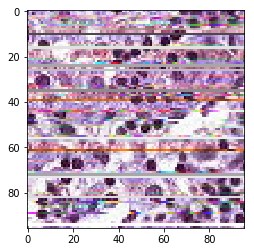

In [104]:
show_random()